<a href="https://colab.research.google.com/github/prav-kotte1/DM-Lab/blob/main/dmLabMajor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

In [3]:
path = kagglehub.dataset_download("larsen0966/student-performance-data-set")
print("Path to dataset files:", path)
df = pd.read_csv(path + "/student-por.csv")
df.head()

Using Colab cache for faster access to the 'student-performance-data-set' dataset.
Path to dataset files: /kaggle/input/student-performance-data-set


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
df['Pass'] = (df['G3'] >= 10).astype(int)

print("Pass/Fail distribution:")
print(df['Pass'].value_counts())

df = df.drop(columns=['G3'])

df.info()

Pass/Fail distribution:
Pass
1    549
0    100
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 n

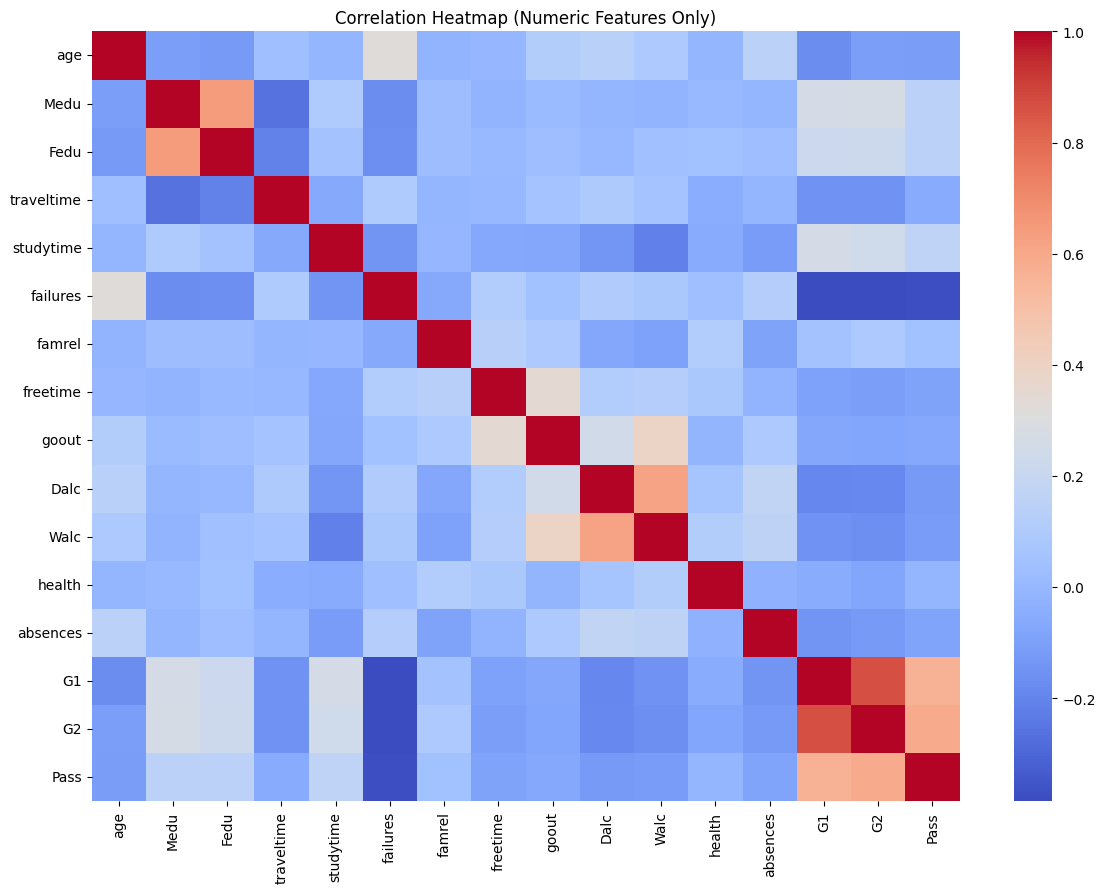

In [6]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(14,10))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [7]:
X = df.drop(columns=['Pass'])
y = df['Pass']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
dt_params = {"max_depth": range(1, 20)}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='f1'
)

dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print("Best Decision Tree:", best_dt)


Best Decision Tree: DecisionTreeClassifier(max_depth=1, random_state=42)


In [9]:
knn_params = {"n_neighbors": range(1, 30)}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring='f1'
)

knn_grid.fit(X_train_scaled, y_train)
best_knn = knn_grid.best_estimator_

print("Best KNN:", best_knn)


Best KNN: KNeighborsClassifier(n_neighbors=7)


In [10]:
def evaluate(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 3))
    print("Precision:", round(precision_score(y_true, y_pred), 3))
    print("Recall   :", round(recall_score(y_true, y_pred), 3))
    print("F1 Score :", round(f1_score(y_true, y_pred), 3))

y_pred_dt = best_dt.predict(X_test)
y_pred_knn = best_knn.predict(X_test_scaled)

evaluate("Decision Tree", y_test, y_pred_dt)
evaluate("KNN", y_test, y_pred_knn)


Decision Tree Performance:
Accuracy : 0.946
Precision: 0.948
Recall   : 0.991
F1 Score : 0.969

KNN Performance:
Accuracy : 0.831
Precision: 0.855
Recall   : 0.964
F1 Score : 0.906


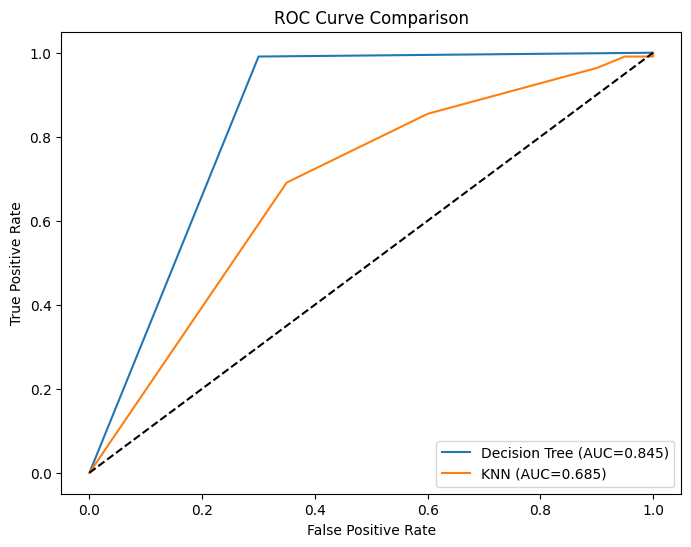

In [11]:
dt_probs = best_dt.predict_proba(X_test)[:, 1]
knn_probs = best_knn.predict_proba(X_test_scaled)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={roc_auc_score(y_test, dt_probs):.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={roc_auc_score(y_test, knn_probs):.3f})")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [12]:
importances = best_dt.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp.head(10)


,Feature,Importance
14,G2,1.0
1,Medu,0.0
2,Fedu,0.0
3,traveltime,0.0
4,studytime,0.0
5,failures,0.0
6,famrel,0.0
7,freetime,0.0
0,age,0.0
8,goout,0.0


Top 5 Most Important Features (Decision Tree):

       Feature  Importance
14          G2         1.0
1         Medu         0.0
2         Fedu         0.0
3   traveltime         0.0
4    studytime         0.0


/tmp/ipython-input-1013941342.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=top5, palette='viridis')


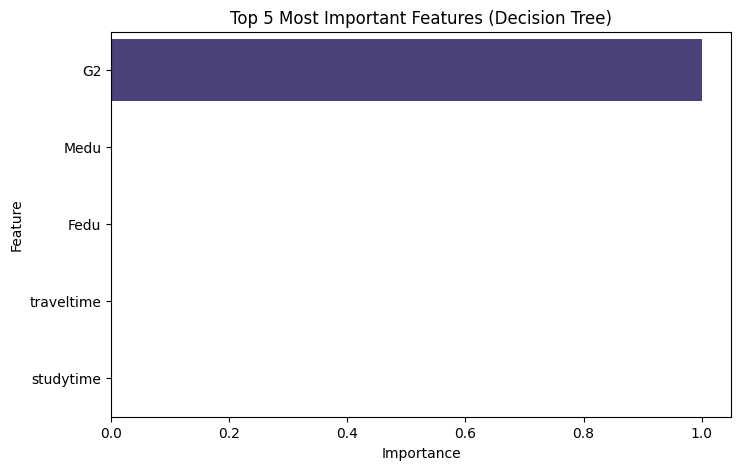

In [14]:
top5 = feat_imp.head(5)
print("Top 5 Most Important Features (Decision Tree):\n")
print(top5)

plt.figure(figsize=(8,5))
sns.barplot(y='Feature', x='Importance', data=top5, palette='viridis')
plt.title("Top 5 Most Important Features (Decision Tree)")
plt.show()
